## Data loading

To work with any kind of data we first have to load it. For this we use a dataloader that reads the images as well as their labels and transforms them into pytorch readable tensors.

In [1]:
import pathlib

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
class RSiMCCDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        # get images
        image_files = [x.resolve() for x in pathlib.Path(".").glob('data/*/*')]
        # Image.open() has a bug, this is a workaround
        self.images=[read_image(str(p)) for p in image_files] 
        # get labels from image path
        labels = [x.parts[-2] for x in image_files]
        self.classes = sorted(list(set(labels)))
        self.labels = [self.label_to_tensor(lbl) for lbl in labels]

        assert len(self.labels) == len(self.images), f"Found {len(self.labels)} labels and {len(self.images)} images"

    def label_to_tensor(self, lbl):
        """
        Converts the string label to a one-hot tensor where every entry is zero except the label which is one.
        
        """
        assert lbl in self.classes, f"Class {lbl} not a valid class (valid classes: {self.classes})"
        t = torch.zeros(len(self.classes))
        t[self.classes.index(lbl)] = 1
        return t

    def tensor_to_label(self, t):
        """
        Returns the classname in string format
        """
        assert len(t.shape) == 1, f"Can only convert 1-dimensional tensors (shape of tensor: {t.shape})"
        assert len(t) == len(self.classes), f"Lenght of tensor ({len(t)}) does not match number of classes ({len(classes)})"
        return self.classes[t.argmax()]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].float()/255
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

## Examples
Now lets load the dataset and look at some examples by just randomly loading the images and their labels

In [3]:
dataset = RSiMCCDataset()

In [4]:
print(f"The dataset consists of {len(dataset)} RGB images of shape {dataset.images[0].shape} labeled in {dataset.labels[0].shape[0]} classes which are " + ', '.join(dataset.classes))

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [5]:
dataset.labels[0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

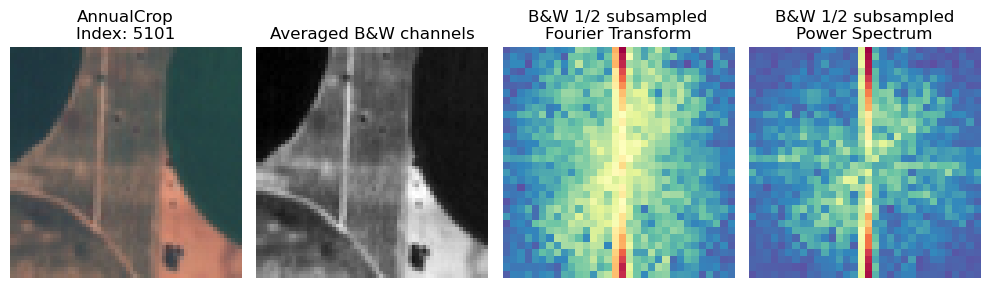

In [6]:
import matplotlib.pyplot as plt
import random
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# First subplot - Display the image
# r = random.randint(0, len(dataset))
r = 5101
img, lbl = dataset[r]
axs[0].imshow(img.permute(1, 2, 0))
axs[0].axis('off')
axs[0].set_title(dataset.tensor_to_label(lbl) + "\nIndex: " + str(r))


# Second subplot - Display the first channel of the image
bnw_image = torch.sum(dataset[r][0], axis=0)
fourier_transform = torch.fft.fftshift(torch.fft.fft2(bnw_image))
fourier_transform = torch.abs(fourier_transform)


axs[1].imshow(bnw_image, cmap='gray')
axs[1].set_title("Averaged B&W channels")
axs[1].axis('off')
axs[1].set_aspect('equal')  # Make sure the aspect ratio is equal

# Third subplot - Display the Fourier transform
spectrum = torch.log(1 + fourier_transform)
spectrum = torch.nn.AvgPool2d(kernel_size=2)(torch.unsqueeze(spectrum, 0))
spectrum = torch.nn.functional.normalize(torch.squeeze(spectrum), p=2)
axs[2].imshow(spectrum, cmap='Spectral_r')
axs[2].set_title("B&W 1/2 subsampled\nFourier Transform")
axs[2].axis('off')

# Fourth subplot - Display the power spectrum
# Calculate a map of frequency powers
center_x, center_y = fourier_transform.shape[1] // 2, fourier_transform.shape[0] // 2
power_x, power_y = torch.meshgrid(torch.arange(fourier_transform.shape[0]), torch.arange(fourier_transform.shape[1]), indexing='ij')
powers = torch.sqrt((power_x - center_x)**2 + (power_y - center_y)**2)
powers = powers.to(torch.int)

# Compute the power spectrum
power_map = powers * fourier_transform
power_map = torch.abs(power_map)


power_spectrum = power_map
power_spectrum = torch.nn.AvgPool2d(kernel_size=2)(torch.unsqueeze(power_spectrum, 0))
power_spectrum = torch.nn.functional.normalize(torch.squeeze(power_spectrum), p=2)
axs[3].imshow(power_spectrum, cmap='Spectral_r')
axs[3].set_title("B&W 1/2 subsampled\nPower Spectrum")
axs[3].axis('off')

# Show the figure with all three subplots
plt.tight_layout()
plt.show()

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian

def process_indices(dataset, indices):
    fig, axs = plt.subplots(len(indices), 4, figsize=(8, 2.5*len(indices)))
    results = []
    for i, r in enumerate(indices):
        img, lbl = dataset[r]
        # img = torch.tensor(gaussian(img.permute(1, 2, 0), sigma=.6), dtype=torch.float32).permute(2, 0, 1)
        bnw_image = torch.sum(img, axis=0)
        fourier_transform = torch.fft.fftshift(torch.fft.fft2(bnw_image))
        fourier_transform = torch.abs(fourier_transform)
        spectrum = torch.log(1 + fourier_transform)
        spectrum = torch.nn.AvgPool2d(kernel_size=2)(torch.unsqueeze(spectrum, 0))
        spectrum = torch.nn.functional.normalize(torch.squeeze(spectrum), p=2)
        center_x, center_y = fourier_transform.shape[1] // 2, fourier_transform.shape[0] // 2
        power_x, power_y = torch.meshgrid(torch.arange(fourier_transform.shape[0]), torch.arange(fourier_transform.shape[1]), indexing='ij')
        powers = torch.sqrt((power_x - center_x)**2 + (power_y - center_y)**2)
        powers = powers.to(torch.int)
        power_map = powers * fourier_transform
        power_map = torch.abs(power_map)
        power_spectrum = power_map
        power_spectrum = torch.nn.AvgPool2d(kernel_size=2)(torch.unsqueeze(power_spectrum, 0))
        power_spectrum = torch.nn.functional.normalize(torch.squeeze(power_spectrum), p=2)
        axs[i, 0].imshow(img.permute(1, 2, 0))
        axs[i, 0].axis('off')
        axs[i, 0].set_title(dataset.tensor_to_label(lbl) + "\nIndex: " + str(r))
        axs[i, 1].imshow(bnw_image, cmap='gray')
        axs[i, 1].set_title("Averaged B&W channels")
        axs[i, 1].axis('off')
        axs[i, 1].set_aspect('equal')
        axs[i, 2].imshow(spectrum, cmap='Spectral_r')
        axs[i, 2].set_title("B&W 1/2 subsampled\nFourier Transform")
        axs[i, 2].axis('off')
        axs[i, 3].imshow(power_spectrum, cmap='Spectral_r')
        axs[i, 3].set_title("B&W 1/2 subsampled\nPower Spectrum")
        axs[i, 3].axis('off')
        results.append((img, bnw_image, spectrum, power_spectrum))
    plt.tight_layout()
    plt.savefig("results.png")
    plt.show()
    return results

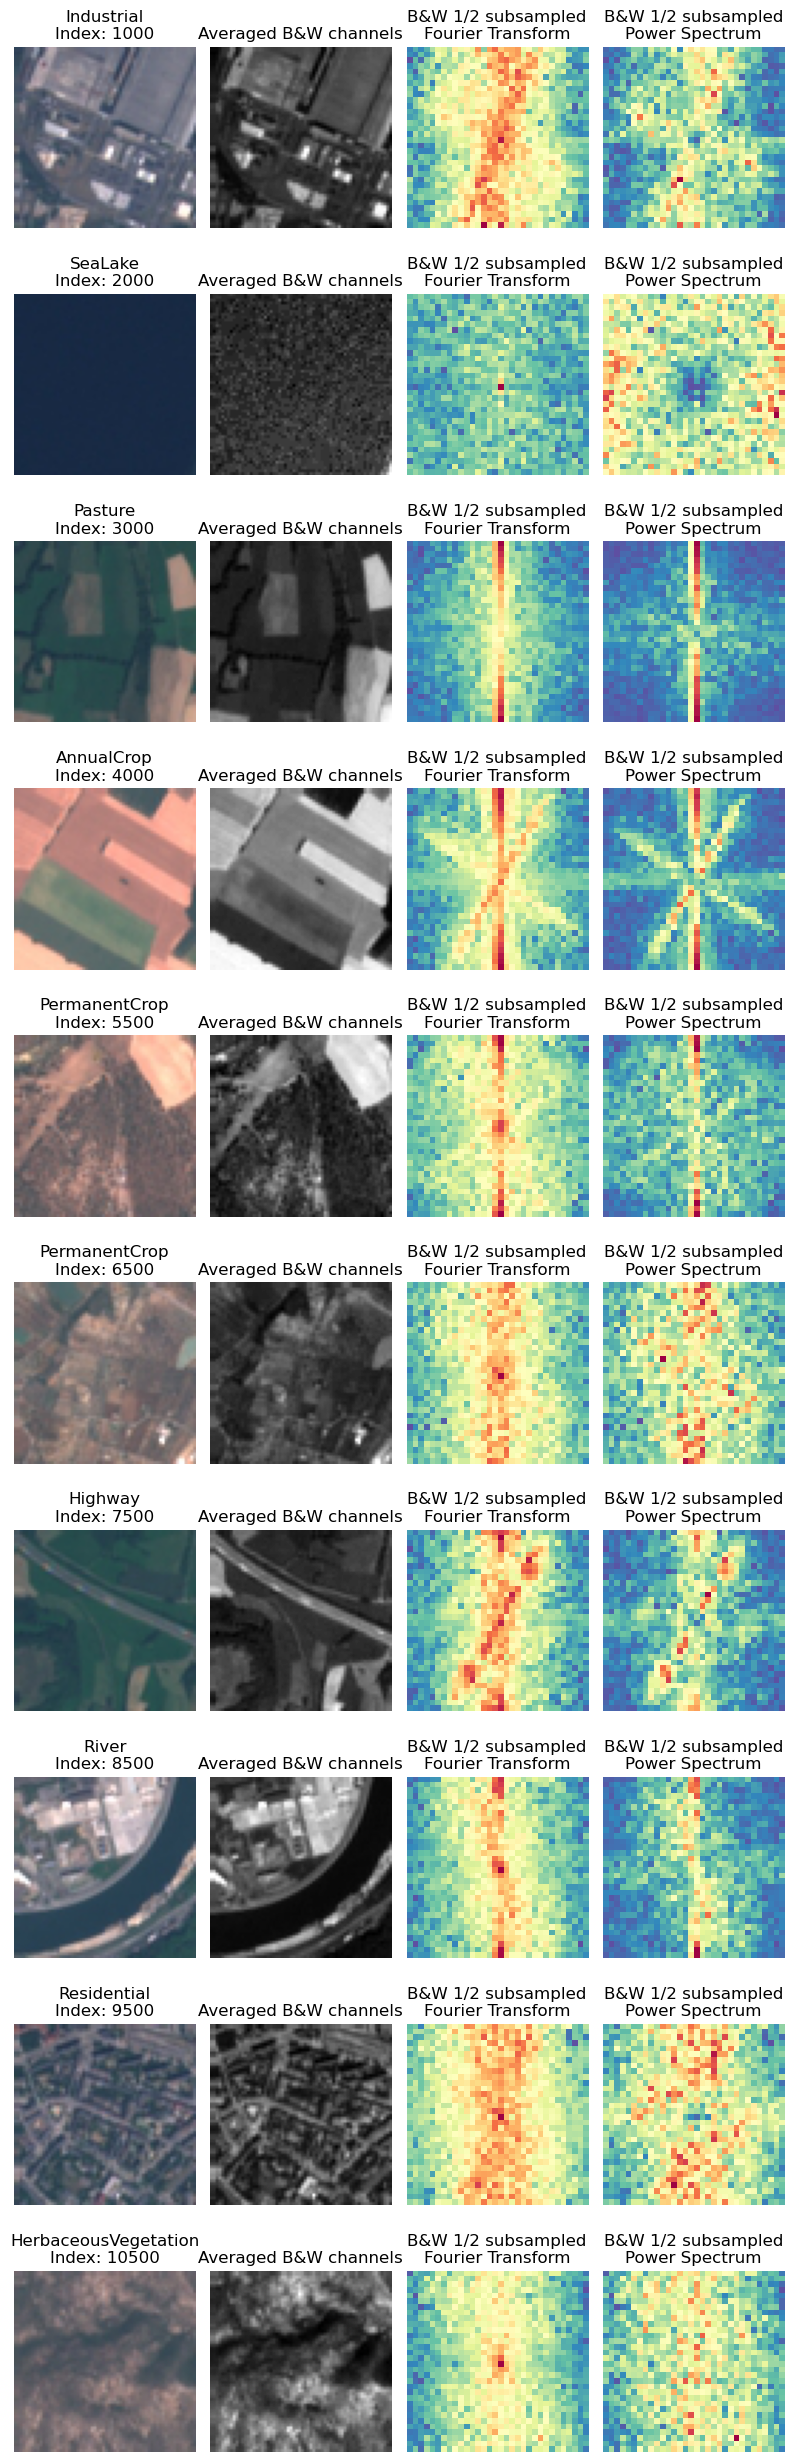

In [8]:
indices = [1000, 2000, 3000, 4000, 5500, 6500, 7500, 8500, 9500, 10500]
results = process_indices(dataset, indices)


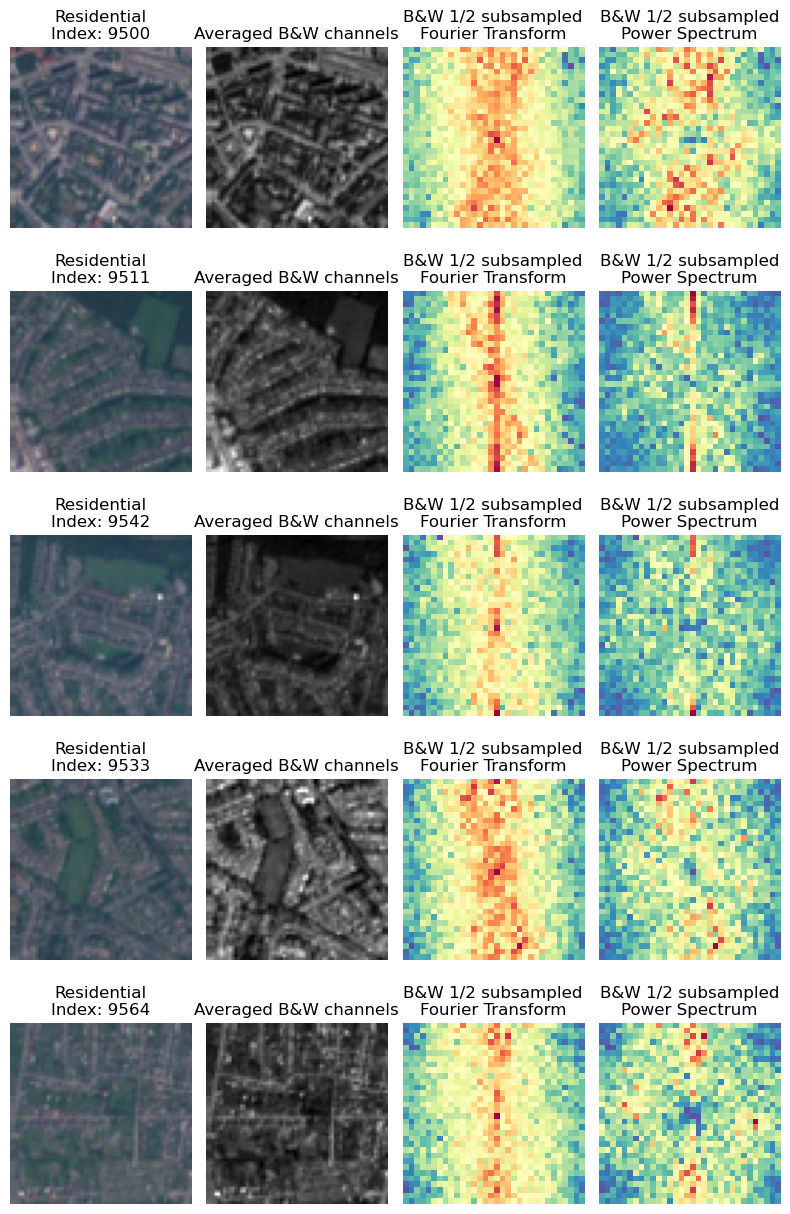

In [9]:
indices = [9500, 9511, 9542, 9533, 9564]
results = process_indices(dataset, indices)

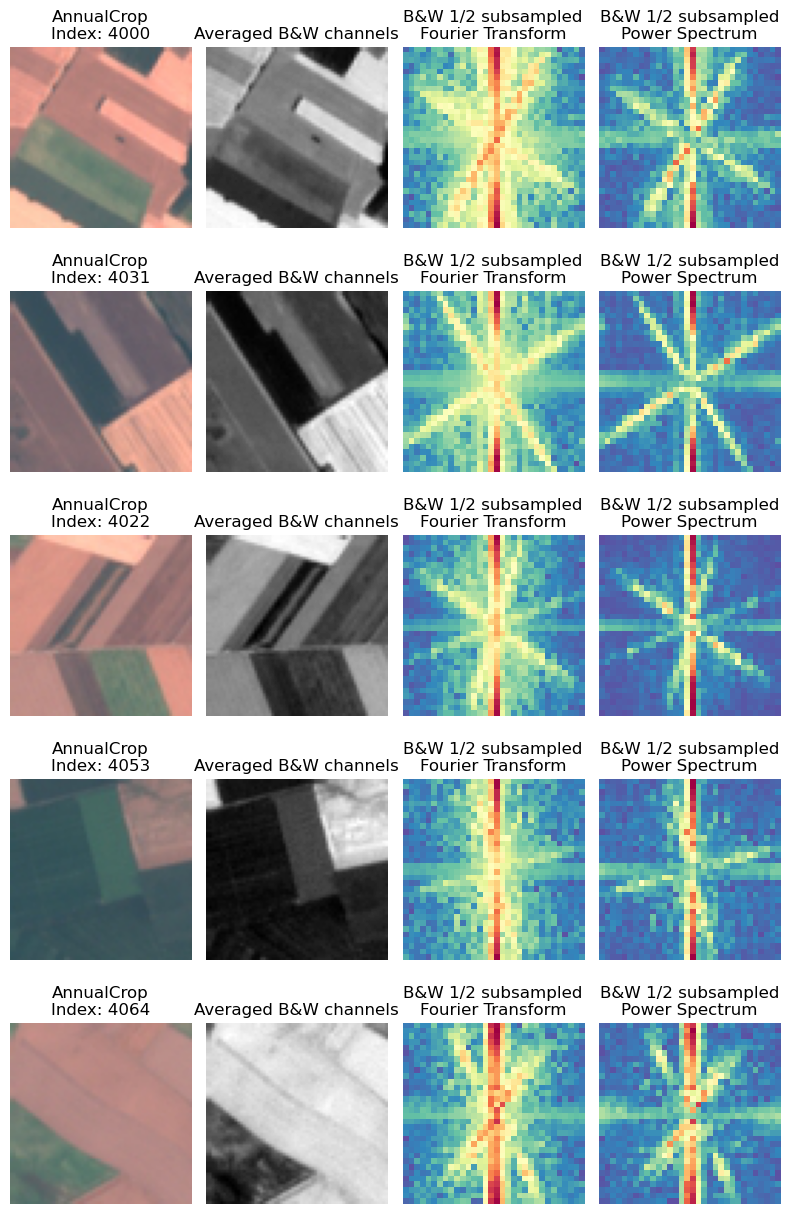

In [10]:
indices = [4000, 4031, 4022, 4053, 4064]
results = process_indices(dataset, indices)

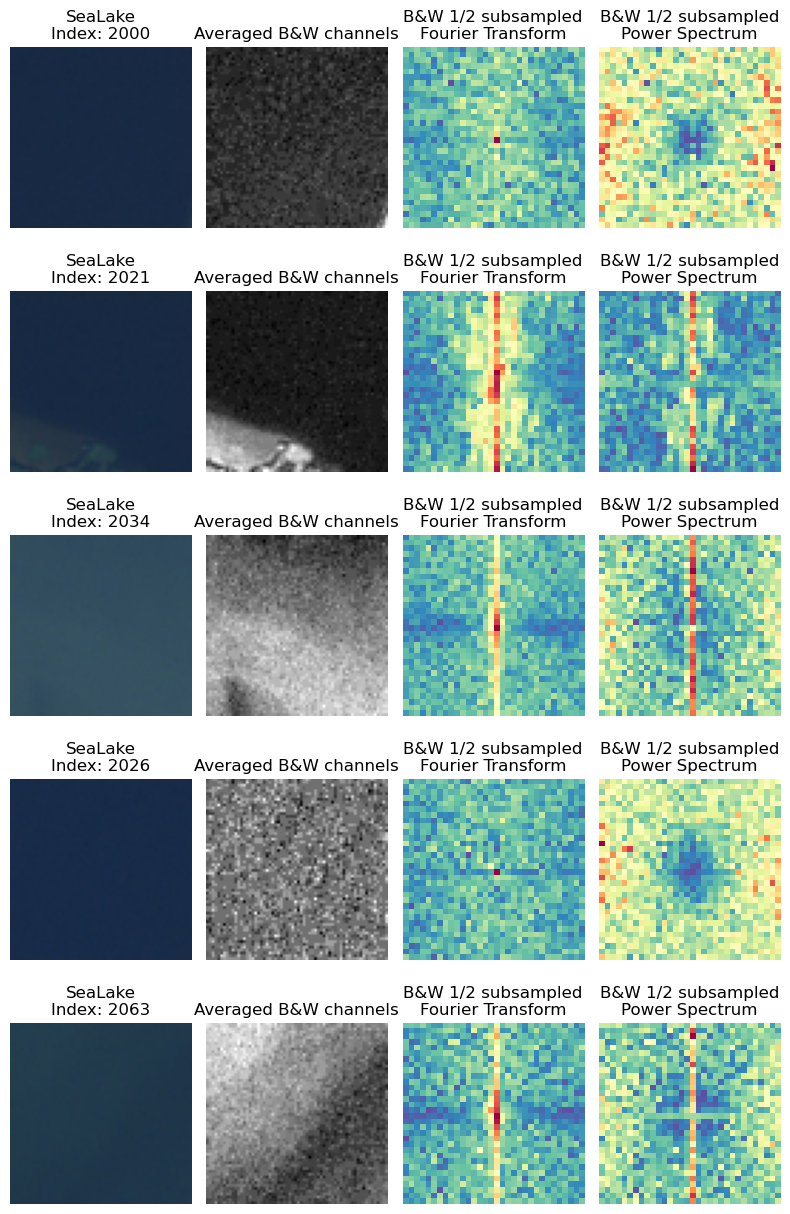

In [11]:
indices = [2000, 2021, 2034, 2026, 2063]
results = process_indices(dataset, indices)

# Create my custom convolution model for the task

In [55]:
class FreqCNN(nn.Module):
    def __init__(self, nb_classes):
        super(FreqCNN, self).__init__()
        # inputs (N,3,64,64)


        # Follows ResNET architecture: Conv2d -> BN -> ReLU (-> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=6, padding=2)
        self.bn1   = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        # no pooling in 1st step

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        # no pooling in 3rd step


        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        # here output is None,16,15,15
        self.bn4   = nn.BatchNorm2d(16)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lin1  = nn.Linear(16*15*15, nb_classes) # adapt here!

        # Processing of frequencies
        self.pool_freq  = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1_freq = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)
        self.conv2_freq = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5)
        # here output is None,8,7,7
        self.bn_freq    = nn.BatchNorm2d(8)
        self.relu_freq  = nn.ReLU()
        self.lin_freq   = nn.Linear(8*24*24, nb_classes) # adapt here!

        self.final_lin  = nn.Linear(2*nb_classes, nb_classes)


        
    def forward(self, x):

        freq_data = torch.sum(x, axis=1, keepdim=True)
        freq_data = torch.fft.fft2(freq_data)
        freq_data = torch.fft.fftshift(freq_data)
        freq_data = torch.abs(freq_data)
        freq_data = torch.log(1 + freq_data)

        freq_data = self.pool_freq(freq_data)
        freq_data = self.conv1_freq(freq_data)
        freq_data = self.conv2_freq(freq_data)
        
        freq_data = self.bn_freq(freq_data)
        freq_data = self.relu2(freq_data)
        
        # outputs (None, 8, 7, 7)
        freq_data = self.lin_freq(freq_data.view(-1, 8*24*24))  # adapt here!

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = x + self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x + self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = x + self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        # outputs (None, 16, 15, 15)
        x = self.lin1(x.view(-1, 16*15*15))  # adapt here!

        output = torch.cat((x, freq_data), dim=1)
        output = self.final_lin(output)
        return output


In [56]:
def get_model(nb_classes):
    return FreqCNN(nb_classes)

In [57]:
# Create a dummy image to test input of the network
dummy_img = torch.rand(42, 3, 64, 64)
dummy_freq = torch.sum(dummy_img, axis=1, keepdim=True)
print(dummy_img.shape)
print(dummy_freq.shape)

res = nn.AvgPool2d(kernel_size=2, stride=2)(dummy_freq)
print(res.shape)
res = nn.BatchNorm2d(1)(res)
print(res.shape)

torch.Size([42, 3, 64, 64])
torch.Size([42, 1, 64, 64])
torch.Size([42, 1, 32, 32])
torch.Size([42, 1, 32, 32])


In [58]:
model = get_model(len(dataset.classes))
model(dummy_img).shape

torch.Size([42, 10])

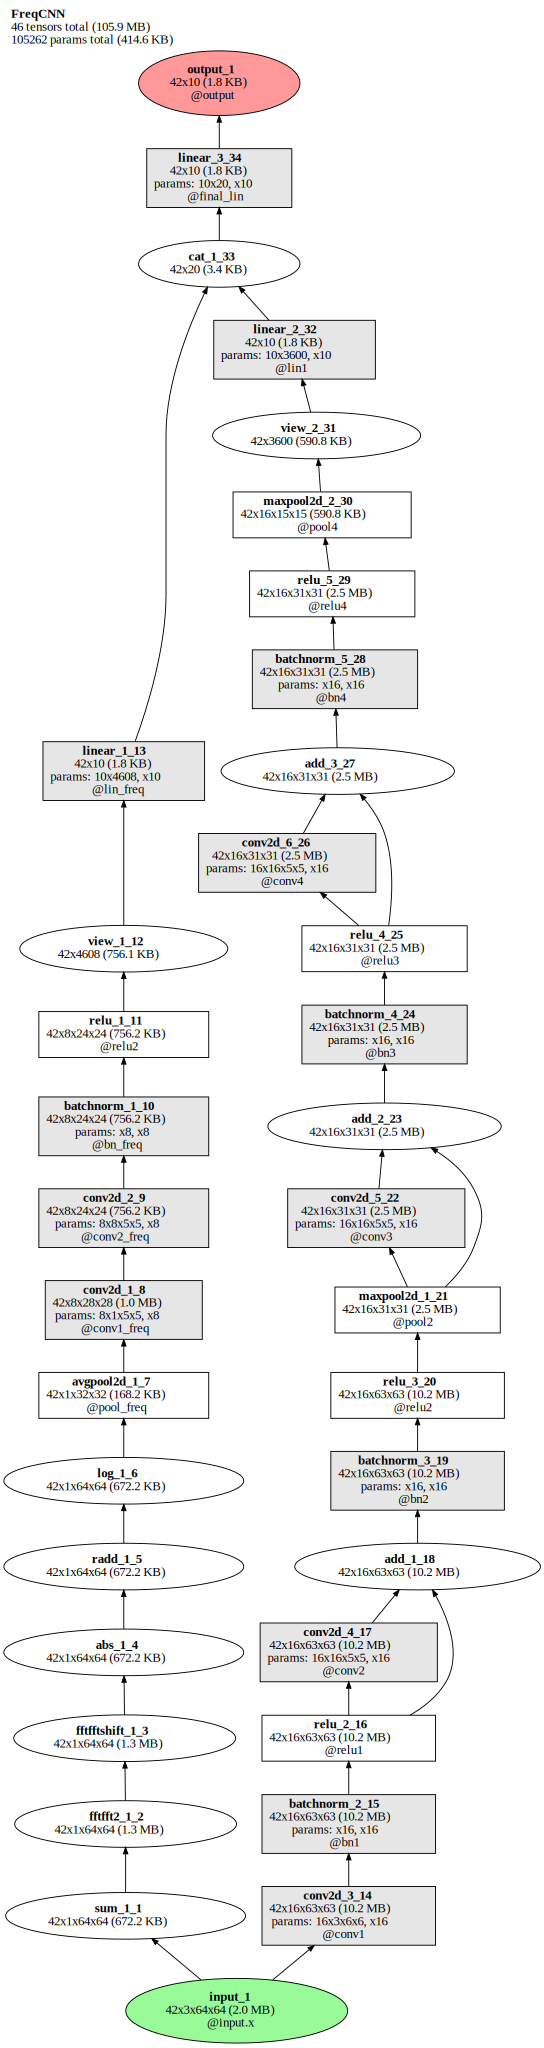

Log of FreqCNN forward pass:
	Random seed: 2972011442
	Time elapsed: 9.433s (9.37s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- with branching
		- no conditional (if-then) branching
		- contains 10 buffer layers
		- 21 total modules
	Tensor info:
		- 46 total tensors (105.9 MB) computed in forward pass.
		- 46 tensors (105.9 MB) with saved activations.
	Parameters: 14 parameter operations (105262 params total; 414.6 KB)
	Module Hierarchy:
		pool_freq
		conv1_freq
		conv2_freq
		bn_freq
		relu2:1
		lin_freq
		conv1
		bn1
		relu1
		conv2
		bn2
		relu2:2
		pool2
		conv3
		bn3
		relu3
		conv4
		bn4
		relu4
		pool4
		lin1
		final_lin
	Layers (all have saved activations):
		  (0) input_1 
		  (1) sum_1_1 
		  (2) fftfft2_1_2 
		  (3) fftfftshift_1_3 
		  (4) abs_1_4 
		  (5) radd_1_5 
		  (6) log_1_6 
		  (7) avgpool2d_1_7 
		  (8) conv2d_1_8 
		  (9) conv2d_2_9 
		  (10) buffer_1 
		  (11) buffer_2 
		  (12) batchnorm_1_10 
		  (13) relu_1_11 
		  (14) view_1_12 
		 

In [59]:
import torchlens as tl
model_history = tl.log_forward_pass(model, dummy_img, layers_to_save='all', vis_opt='rolled')
print(model_history)

### Initialize the model and dataloader

In [60]:
""" from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loaders for training and validation sets
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) """

' from sklearn.model_selection import train_test_split\n\n# Split dataset into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create data loaders for training and validation sets\ntrain_dataset = MyDataset(X_train, y_train)\nval_dataset = MyDataset(X_val, y_val)\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) '

In [65]:
# Create training and validation datasets
from torch.utils.data import random_split

batch_size = 50
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = DataLoader(dataset, batch_size=50, shuffle=True)

train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


num_classes = len(dataset.classes)
model = get_model(num_classes) # define the model
# model.load_state_dict(torch.load("best_model.pt"))


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


image = torch.randn(20, 3, 64, 64) # create dummy image
output = model(image)

print(model(image).shape) # show the output of one batch of images

from torchinfo import summary
summary(model) # display summary of the model and number of trainable parameters

Feature batch shape: torch.Size([50, 3, 64, 64])
Labels batch shape: torch.Size([50, 10])
torch.Size([20, 10])


Layer (type:depth-idx)                   Param #
FreqCNN                                  --
├─Conv2d: 1-1                            1,744
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            6,416
├─BatchNorm2d: 1-5                       32
├─ReLU: 1-6                              --
├─MaxPool2d: 1-7                         --
├─Conv2d: 1-8                            6,416
├─BatchNorm2d: 1-9                       32
├─ReLU: 1-10                             --
├─Conv2d: 1-11                           6,416
├─BatchNorm2d: 1-12                      32
├─ReLU: 1-13                             --
├─MaxPool2d: 1-14                        --
├─Linear: 1-15                           36,010
├─AvgPool2d: 1-16                        --
├─Conv2d: 1-17                           208
├─Conv2d: 1-18                           1,608
├─BatchNorm2d: 1-19                      16
├─ReLU: 1-20                             --
├─Linea

### Send the model to the GPU

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FreqCNN(
  (conv1): Conv2d(3, 16, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=3600, out_features=10, bias=True)
  (pool_freq): AvgPoo

### Define the training function

In [63]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(train_loader):
            # Move tensors to the configured device
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction and loss
            pred = model(X)

            # Compute loss and its gradients
            loss = loss_fn(pred, y)
            loss.backward()
            

            # Backpropagation step
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y.argmax(1)).sum().item()

            # Display progress
            if batch % 30 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"Epoch {epoch+1}, batch {batch+1}/{len(train_loader)}, loss: {loss:.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, train loss: {train_loss:.4f}, train accuracy: {train_acc:.2f}%")

        # Validation

        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = loss_fn(pred, y)
                running_loss += loss.item()
                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y.argmax(1)).sum().item()
            val_loss = running_loss / len(val_loader)
            val_acc = 100 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Epoch {epoch+1}, val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")
        
            # # Save best model
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            #     torch.save(model.state_dict(), "best_model.pt")

    return train_losses, train_accs, val_losses, val_accs



In [67]:
train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

Epoch 1, batch 1/185, loss: 2.3856
Epoch 1, batch 31/185, loss: 1.6202
Epoch 1, batch 61/185, loss: 1.6993
Epoch 1, batch 91/185, loss: 1.5017
Epoch 1, batch 121/185, loss: 1.4001
Epoch 1, batch 151/185, loss: 1.3062
Epoch 1, batch 181/185, loss: 1.0287
Epoch 1, train loss: 1.4600, train accuracy: 48.29%
Epoch 1, val loss: 1.1448, val accuracy: 60.98%
Epoch 2, batch 1/185, loss: 1.1343
Epoch 2, batch 31/185, loss: 1.3601
Epoch 2, batch 61/185, loss: 1.1269
Epoch 2, batch 91/185, loss: 0.8921
Epoch 2, batch 121/185, loss: 0.9083
Epoch 2, batch 151/185, loss: 0.7574
Epoch 2, batch 181/185, loss: 1.0075
Epoch 2, train loss: 0.9917, train accuracy: 66.34%
Epoch 2, val loss: 0.8951, val accuracy: 70.31%
Epoch 3, batch 1/185, loss: 0.8887
Epoch 3, batch 31/185, loss: 0.8300
Epoch 3, batch 61/185, loss: 0.7213
Epoch 3, batch 91/185, loss: 0.5943
Epoch 3, batch 121/185, loss: 0.6996
Epoch 3, batch 151/185, loss: 0.5380
Epoch 3, batch 181/185, loss: 1.3560
Epoch 3, train loss: 0.7733, train acc

In [ ]:
torch.save(model.state_dict(), "best_model.pt")

In [68]:
import matplotlib.pyplot as plt

def plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs):
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    # Plot loss curves
    ax1.plot(train_losses, label="Training Loss", color="blue")
    ax1.plot(val_losses, label="Validation Loss", color="orange")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")

    # Plot accuracy curves
    ax2.plot(train_accs, label="Training Accuracy", color="green")
    ax2.plot(val_accs, label="Validation Accuracy", color="red")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend(loc="upper right")

    # Set common x-axis label and grid
    ax1.set_xlabel("Epoch")
    ax1.grid()

    plt.show()

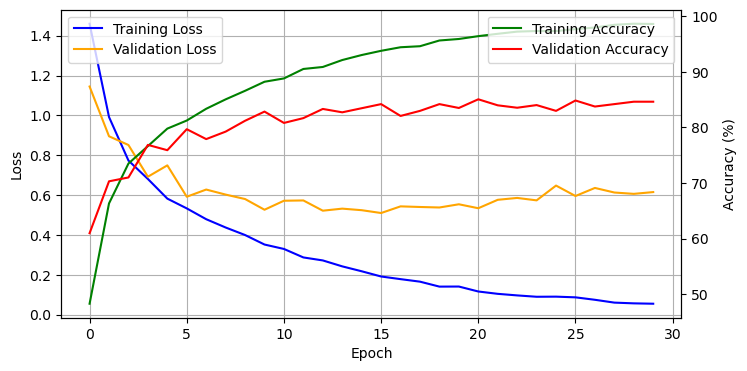

In [69]:
plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs)